In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
heiheihei

# 0.Préparation 


In [56]:
import numpy as np
import pandas as pd

In [57]:
# Il faut changer import path quand vous voulez exécuter ce script
ticket = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/ticket_data.csv')
cities = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/cities.csv')
providers = pd.read_csv('/content/drive/MyDrive/data/exercise_stage/providers.csv')

# 1.Extraire des infos intéressantes

Dans la première partie, pour obtenir le prix et la durée par trajet,
j'ai tout d'abord classifié des infos sur ticket par o_city et d_city, et puis calculer leur value minimum, maximum et moyen.

In [58]:
Prix = ticket.groupby(['o_city', 'd_city'])['price_in_cents'].agg([np.min, np.max, np.mean])
Prix

amin   amax          mean
o_city d_city                            
5      23      18600  22000  20320.000000
6      227      9860  13650  11755.000000
       504      2000   8920   4042.666667
       628      2600   3190   2797.500000
       845       700   2420    864.626866
...              ...    ...           ...
11938  126      3000   5350   4204.861111
12124  1064     6000   7900   6950.000000
12166  857      5300   5300   5300.000000
12190  639       600    850    688.888889
       8937     9800   9800   9800.000000

[1437 rows x 3 columns]

In [59]:
Prix.loc[(6,227)] # Recherche des données sur prix par o_city et d_city

amin     9860.0
amax    13650.0
mean    11755.0
Name: (6, 227), dtype: float64

In [60]:
# Calculer la durée du trajet par arrival_ts et departure_ts
ticket['time'] = pd.to_datetime(ticket['arrival_ts']) - pd.to_datetime(ticket['departure_ts']) 
Time = ticket.groupby(['o_city', 'd_city'])['time'].agg([np.min, np.max, np.mean])
Time

amin            amax                      mean
o_city d_city                                                          
5      23     0 days 08:53:00 0 days 15:54:00           0 days 10:18:48
6      227    0 days 12:24:00 0 days 15:01:00           0 days 13:42:30
       504    0 days 05:36:00 0 days 12:20:00           0 days 08:17:24
       628    0 days 09:40:00 0 days 14:30:00           0 days 12:10:00
       845    0 days 01:00:00 0 days 04:11:00 0 days 01:19:54.626865671
...                       ...             ...                       ...
11938  126    0 days 05:30:00 1 days 11:20:00 0 days 07:25:16.666666666
12124  1064   0 days 11:10:00 0 days 23:10:00           0 days 17:10:00
12166  857    0 days 21:55:00 0 days 21:55:00           0 days 21:55:00
12190  639    0 days 01:10:00 0 days 02:40:00 0 days 01:28:53.333333333
       8937   0 days 09:10:00 0 days 09:10:00           0 days 09:10:00

[1437 rows x 3 columns]

In [61]:
Time.loc[(6,227)] # Recherche des données sur durée par o_city et d_city

amin   0 days 12:24:00
amax   0 days 15:01:00
mean   0 days 13:42:30
Name: (6, 227), dtype: timedelta64[ns]

# 2.différence du prix moyen et la durée 

Dans la deuxième partie, je voudrais obtenir prix moyen et durée selon le train, le bus et le covoit selon la distance du trajet. 

Tout d'abord, pour obtenir la distance entres deux villes, j'ai utilisé haversine pour les calculer par longitudes et latitudes des ces villes. Aussi, j'ai fusionné 3 dataframes pour obtenir les infos de o_city, d_city et company.



In [62]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
from haversine import haversine

In [64]:
# Changer le nom des colonnes pour ne pas les mélanger
cities = cities.rename(columns={'id':'id_city'})
ticket = ticket.rename(columns={'id':'id_ticket'})
# Fusionner les deux dataframes pour obtenir les infos de o_city et d_city
ticket_cities = pd.merge(ticket, cities, left_on='o_city', right_on='id_city', how='inner')
ticket_cities = pd.merge(ticket_cities, cities, left_on='d_city', right_on='id_city', how='inner')

In [65]:
# Ajouter une colonne de distance entre o_city et d_city
def get_distance(x):
  lat1 = x['latitude_x']
  lon1 = x['longitude_x']
  lat2 = x['latitude_y']
  lon2 = x['longitude_y']
  return round(haversine((lat1, lon1),(lat2, lon2)),3)

ticket_cities.loc[:,'distance'] = ticket_cities.apply(get_distance, axis=1)


In [66]:
# La même moyen pour obtenir les infos de company
providers = providers.rename(columns={'id':'id_provider'})
ticket_cities_providers = pd.merge(ticket_cities, providers, left_on='company', right_on='id_provider', how='inner')

Et puis, j'ai extrait les trajets par la distance (0-200km, 200-800km, 800-2000km). Il n'y pas trajets dont la distance est supérieure que 2000km.

Et j'ai calculé le prix moyen et la durée moyenne des trajet par la distance pour chaque type de transport. 

In [67]:
# 0-200km
D200 = ticket_cities_providers.loc[ticket_cities_providers['distance']<200, :]
D200.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,2182.830918,0 days 10:13:57.053140096
carpooling,1177.352385,0 days 01:57:07.342427561
train,3487.900779,0 days 04:25:09.840098400


In [68]:
# 200-800km
D800 = ticket_cities_providers.loc[(ticket_cities_providers['distance']>200)& (ticket_cities_providers['distance']<800), :]
D800.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,3494.850022,0 days 15:04:29.269314709
carpooling,3218.064310,0 days 04:45:47.272436410
train,9124.779489,0 days 07:40:39.543514566


In [69]:
# 800-2000km
D2000 = ticket_cities_providers.loc[(ticket_cities_providers['distance']>800)& (ticket_cities_providers['distance']<2000), :]
D2000.groupby('transport_type').agg({'price_in_cents':np.mean, 'time':np.mean})

,price_in_cents,time
transport_type,,
bus,6949.950045,1 days 03:32:10.027247956
carpooling,8626.545455,0 days 13:06:00.839160839
train,15463.746130,0 days 12:09:31.021671826


# 3.Plus d'infos intéressants 

(1) Par la distance des trajets, j'ai calculé la vitesse et le prix par distance. Alors ceci peux donner des voyageurs un petit conseil à choisir le transport. 

(2) Je montre comment les prix des billets évoluent tout au long de la journée, du matin au soir. Quand on choisi o_city, d_city, date et type de transport pour la function predict, elle peut montrer la fluctuation du prix des billets

In [70]:
# Je veux construire un dataframe petit qui contient seulement les colonnes utiles dans cette partie
short = ticket_cities_providers.copy()
short = short.loc[:,['id_ticket','company','price_in_cents','time','distance','transport_type']]

In [71]:
# Transformer la durée à type minute  
short.loc[:, 'time'] = short['time'] / np.timedelta64(1,'m')

In [72]:
short['velocity'] = short['distance'] /short['time'] * 60
short['price_distance'] = short['price_in_cents'] / short['distance']

In [73]:
short.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean})

,velocity,price_distance
transport_type,,
bus,35.772984,9.203141
carpooling,75.038035,8.907696
train,75.572234,22.380288


En général, on peut voir que train et carpooling sont plus rapide que bus, mais le train est plus cher que bus et carpooling. 

In [74]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Le prix par kilometre de differents longeurs')

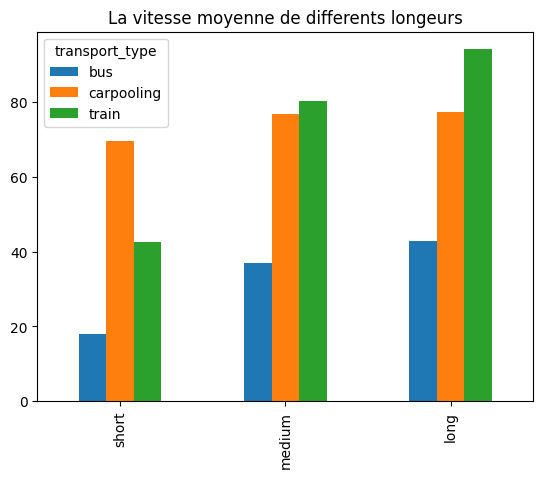

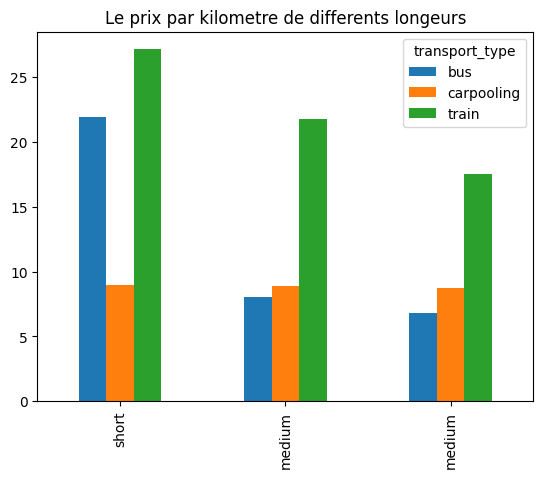

In [75]:
s200 = short.loc[short['distance']<200, :]
v200 = s200.groupby('transport_type')['velocity'].agg(np.mean).rename('short')
p200 = s200.groupby('transport_type')['price_distance'].agg(np.mean).rename('short')

s800 = short.loc[(short['distance']>200) & (short['distance']<800), :]
v800 = s800.groupby('transport_type')['velocity'].agg(np.mean).rename('medium')
p800 = s800.groupby('transport_type')['price_distance'].agg(np.mean).rename('medium')

s2000 = short.loc[(short['distance']>800) & (short['distance']<2000), :]
v2000 = s2000.groupby('transport_type')['velocity'].agg(np.mean).rename('long')
p2000 = s2000.groupby('transport_type')['price_distance'].agg(np.mean).rename('medium')

velocity = pd.concat([v200,v800,v2000], axis=1)
velocity.T.plot.bar()
plt.title('La vitesse moyenne de differents longeurs')
price_distance = pd.concat([p200,p800,p2000], axis=1)
price_distance.T.plot.bar()
plt.title('Le prix par kilometre de differents longeurs')

# print(s200.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}),'\n',
#    s800.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}),'\n',
#    s2000.groupby('transport_type').agg({'velocity':np.mean, 'price_distance':np.mean}))

Dans la figure 1, on peut voir que de la courte à la longue distance, la vitesse moyenne des trains et des bus est de plus en plus élevée. Mais la vitesse de carpooling reste presque la même.

Dans la figure 2, on peut voir que de la courte à la longue distance, le prix moyen de train et bus diminue mais celui de carpooling reste preque la même. 

In [76]:
import matplotlib.ticker as ticker

In [77]:
def prediction(depart,destination,date,transport):
  ticket_cities = pd.merge(ticket, cities, left_on='o_city', right_on='id_city', how='inner')
  ticket_cities = pd.merge(ticket_cities, cities, left_on='d_city', right_on='id_city', how='inner')
  ticket_cities_providers = pd.merge(ticket_cities, providers, left_on='company', right_on='id_provider', how='inner')

  city = ticket_cities_providers.copy()
  city = city.loc[:,['id_ticket','price_in_cents','departure_ts','search_ts','o_city','d_city','transport_type']]
  city = city[city['departure_ts'].str.startswith(date)] # input the date
  city = city.loc[(city['o_city']==depart) & (city['d_city']==destination) & (city['transport_type']==transport) ] #input the depart,destination and type of transport
  
  if city.shape[0] == 0:
    print('No such trajet !!!')
    return 

  city['price_average'] = city.departure_ts.map(city.groupby(['departure_ts']).price_in_cents.mean())

  city = city.drop_duplicates('price_average',keep='first')
  city = city.set_index('departure_ts')
  city = city.sort_values(by='departure_ts')

  fig = city['price_average'].plot()
  fig.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
  plt.xticks(rotation = 45) 
  plt.show()


Nous pouvons constater que, pour un même voyage, le prix du billet varie en fonction de l'heure à laquelle nous consultons le site. Nous prenons donc la moyenne des prix des billets à différents moments comme prix du billet pour ce jour-là.

Si il n y a pas ce trajet, elle imprime "No such trajet!"

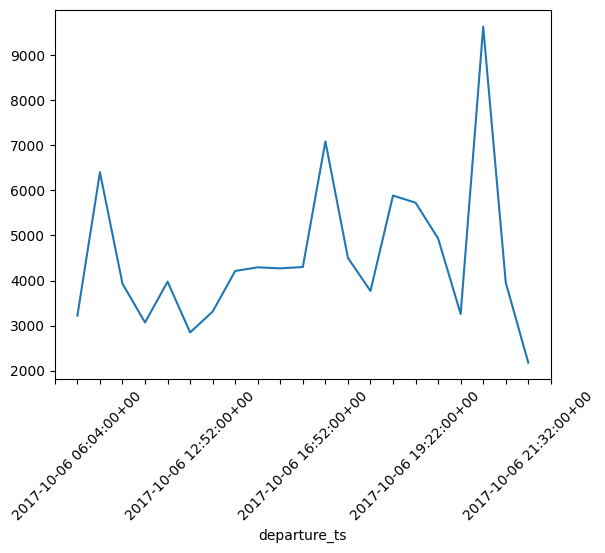

In [78]:
prediction(628,453,'2017-10-06','train')

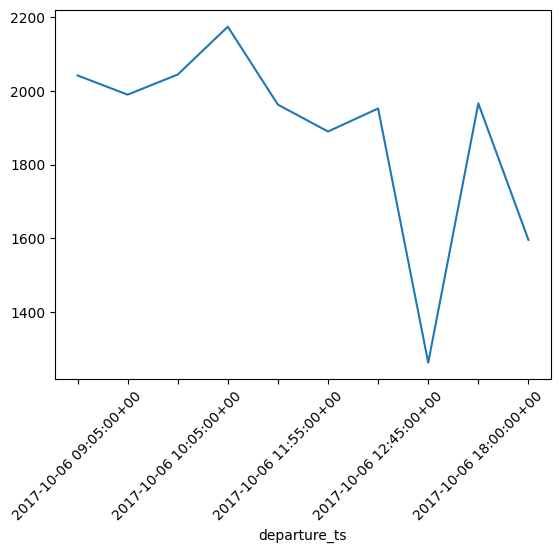

In [79]:
prediction(628,453,'2017-10-06','bus')

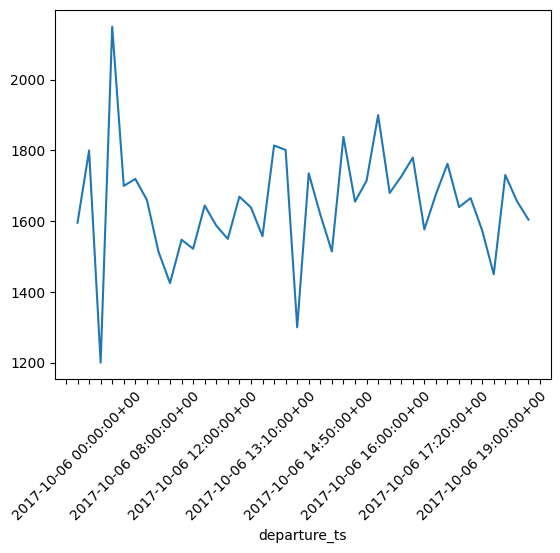

In [80]:
prediction(628,453,'2017-10-06','carpooling')

In [81]:
prediction(628,453,'2017-10-07','carpooling')

No such trajet !!!
